In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
from dataset.translate import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
import wandb
from image_dataset import ImageDataset

# Import data

In [66]:
def translate_label(dirname: str, mapping: dict[str, str]) -> str:
    translated = mapping.get(dirname, dirname)
    return translated

In [67]:
df = pd.DataFrame()
data = []

for (dirpath, dirnames, filenames) in os.walk("./dataset/raw-img"):
    if filenames:
        label = os.path.basename(dirpath)
        translated_label = translate_label(label, translate_it_to_en)
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            data.append({'label': translated_label, 'filepath': filepath})

df = pd.DataFrame(data)
df

,label,filepath
0,horse,./dataset/raw-img/cavallo/OIP-Zt_gJOr3VgDf5OIH...
1,horse,./dataset/raw-img/cavallo/OIP-JHjm7qi-NPKbm6Y6...
2,horse,./dataset/raw-img/cavallo/OIP-fVK0WNvTbadfx3iu...
3,horse,./dataset/raw-img/cavallo/OIP-0bwtSS3fDZVvvGsv...
4,horse,./dataset/raw-img/cavallo/OIP-VVh_bA9absUFvQgk...
...,...,...
26174,elephant,./dataset/raw-img/elefante/OIP-ahvzPqBK9Gx4jkJ...
26175,elephant,./dataset/raw-img/elefante/OIP-QeF6RwJQuXjYWQO...
26176,elephant,./dataset/raw-img/elefante/eb35b70c2dfd033ed15...
26177,elephant,./dataset/raw-img/elefante/OIP-BZi4YoH0juoTJba...


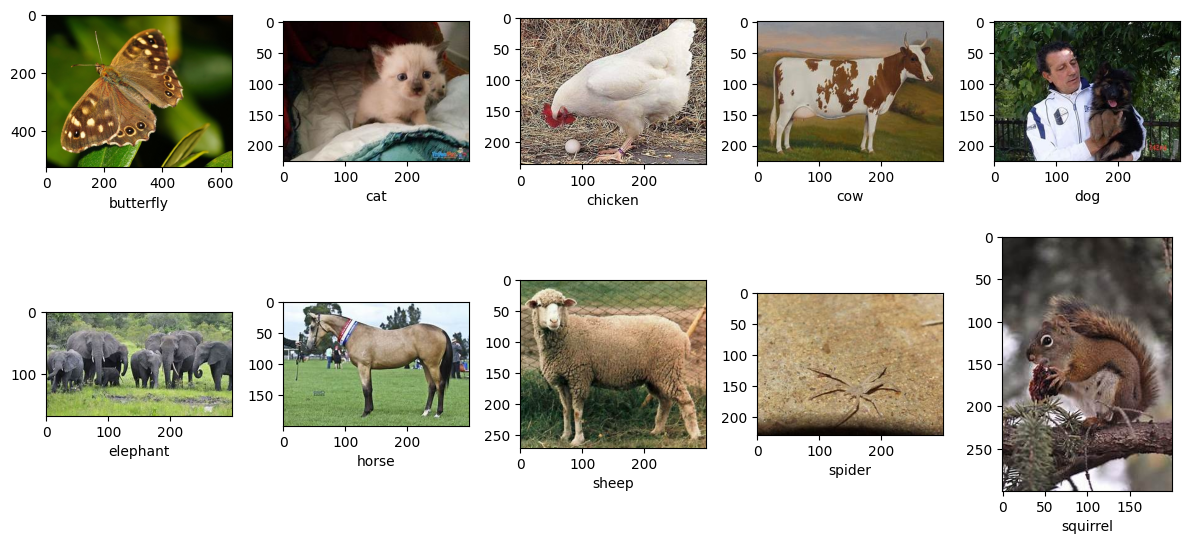

In [68]:
sample_df = df.groupby('label').first().reset_index()
_, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(sample_df.iterrows()):
    filename =  row["filepath"] # type: ignore
    category =  row["label"] # type: ignore
    img = Image.open(filename).convert("RGB")
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_xlabel(category)
plt.tight_layout()
plt.show()

# Label encoding

In [69]:
labelEncoding = {label: str(idx) for idx, label in enumerate(df['label'].unique())}
df['label_encoded'] = df['label'].map(labelEncoding)
df.groupby('label_encoded').first().head(df['label'].nunique())

,label,filepath
label_encoded,,
0,horse,./dataset/raw-img/cavallo/OIP-Zt_gJOr3VgDf5OIH...
1,dog,./dataset/raw-img/cane/OIP-SsSkkIJdnBIFjTCoM_k...
2,sheep,./dataset/raw-img/pecora/OIP-cIbJXpiYS7CGwvN9P...
3,cow,./dataset/raw-img/mucca/OIP-AdJGFK-LwGPzjxYMoi...
4,butterfly,./dataset/raw-img/farfalla/ed36b10d28f71c22d25...
5,squirrel,./dataset/raw-img/scoiattolo/OIP-hdCQmaivLhkpo...
6,chicken,./dataset/raw-img/gallina/OIP-UVDb_9R9ETkp7D0-...
7,spider,./dataset/raw-img/ragno/OIP-aTBY00TQe1ifiZHUIL...
8,cat,./dataset/raw-img/gatto/1523.jpeg


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          26179 non-null  object
 1   filepath       26179 non-null  object
 2   label_encoded  26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


# Splitting data

In [71]:
def split_data(df: pd.DataFrame, test_size: float, val_size: float, random_state: int):
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label_encoded'],
        random_state=random_state
    )

    val_relative_size = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df['label_encoded'],
        random_state=random_state
    )

    train_x = train_df['filepath']
    train_y = train_df['label_encoded']

    val_x = val_df['filepath']
    val_y = val_df['label_encoded']

    test_x = test_df['filepath']
    test_y = test_df['label_encoded']

    return train_x, train_y, val_x, val_y, test_x, test_y

In [72]:
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df, test_size=0.3, val_size=0.2, random_state=880055535)

# Pipeline transformations

In this part we want to find mean / std for our dataset for normalization

Resize images to 128x128 because from eda we know that are mean size of images is around 320*252, so resizing to 128x128 will not lose much information but will speed up training process significantly. Also images are have good quality so downsizing is ok.

In [73]:
tr = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

In [74]:
# dataset = ImageDataset(train_x, train_y, transform=tr)
# loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

# mean = 0.
# std = 0.
# total_images = 0

# for images, _ in loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     total_images += batch_samples

# mean /= total_images
# std /= total_images
# print(f"Mean: {mean}")
# print(f"Std: {std}")
mean = [0.5172, 0.5003, 0.4131]
std = [0.2084, 0.2082, 0.2101]

now we can add normaliser for all pipelines

In [75]:
tr_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [76]:
train_dataset = ImageDataset(val_x, val_y, transform=tr)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

train_dataset_norm = ImageDataset(val_x, val_y, transform=tr_norm)
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True, num_workers=2)

test_dataset = ImageDataset(test_x, test_y, transform=tr_norm)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [77]:
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
class baseCNN(nn.Module):
    def __init__(self, num_classes, conv_dropouts=None, linear_dropout=0.2, filters=None):
        super().__init__()

        # Default architecture
        if filters is None:
            filters = [32, 128, 256, 512]
        if conv_dropouts is None:
            conv_dropouts = [0.2, 0.2, 0.2, 0.25]

        self.model = nn.Sequential(
            self.conv_block(3, filters[0], conv_dropouts[0]),
            self.conv_block(filters[0], filters[1], conv_dropouts[1]),
            self.conv_block(filters[1], filters[2], conv_dropouts[2]),
            self.conv_block(filters[2], filters[3], conv_dropouts[3]),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(filters[3], 128),
            nn.ReLU(),
            nn.Dropout(linear_dropout),
            nn.Linear(128, num_classes)
        )

    def conv_block(self, in_chanel, out_chanel, drop):
        return nn.Sequential(
            nn.Conv2d(in_chanel, out_chanel, 3, padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(),

            nn.Conv2d(out_chanel, out_chanel, 3, padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(),

            nn.MaxPool2d(3),  # Note: using 3 instead of 2
            nn.Dropout(drop)
        )

    def forward(self, x):
        return self.model(x)


In [78]:
def predict_all(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.cpu().numpy())
    return np.array(preds)

In [79]:
num_classes = len(labelEncoding)

In [80]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, train_loader: DataLoader, num_epochs=5):
    loss_vals=  []
    for epoch in range(num_epochs):
        loss = 0
        epoch_loss= []
        for _, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()

            epoch_loss.append(loss.item())
            optimizer.step()

        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals

def evaluate(loader, model):
    """
        @returns: (all_preds, all_targets)
    """
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, pred = scores.max(1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    return all_preds, all_targets


Adam was used because nowadays it is mostly used optimizer. It combines RMSProp with momentum and bias correction, which adjusts the deviations at the start of the algorithm and speeds up the convergence

## Training the model for check the difference between pipelines with and without normalization

In [81]:
model_regular = baseCNN(num_classes).to(device)
loss_vals_regular = train(model_regular, torch.optim.Adam(model_regular.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
model_norm = baseCNN(num_classes).to(device)
loss_vals_norm = train(model_norm, torch.optim.Adam(model_norm.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader_norm)

0 Current Loss: tensor(1.8141, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6186, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.3917, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.1074, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(0.9439, device='cuda:0', grad_fn=<NllLossBackward0>)
0 Current Loss: tensor(1.7206, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.5189, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.2991, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.1060, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(0.9993, device='cuda:0', grad_fn=<NllLossBackward0>)


after we train our model we can evaluate it on train and test datasets, so we can check if there any difference in accuracy between pipelines with and without normalization

<Axes: >

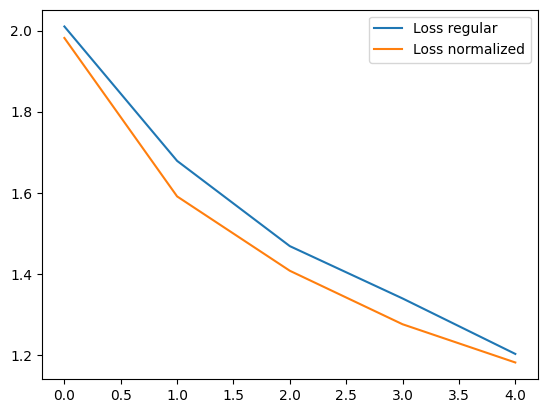

In [82]:
sns.lineplot(x=range(len(loss_vals_regular)), y=loss_vals_regular, label="Loss regular")
sns.lineplot(x=range(len(loss_vals_norm)), y=loss_vals_norm, label="Loss normalized")

## Evaluating the model for both pipelines

### Pipeline without normalization

In [88]:
train_pred_regular, train_target_regular = evaluate(train_loader, model_regular)
test_pred_regular, test_target_regular = evaluate(test_loader, model_regular)
print(classification_report(train_target_regular, train_pred_regular))
print(classification_report(test_target_regular, test_pred_regular))

              precision    recall  f1-score   support

           0       0.58      0.23      0.33       525
           1       0.67      0.56      0.61       973
           2       0.29      0.85      0.44       364
           3       0.40      0.23      0.29       373
           4       0.79      0.76      0.77       422
           5       0.53      0.34      0.42       372
           6       0.84      0.70      0.76       620
           7       0.68      0.90      0.77       964
           8       0.49      0.09      0.15       334
           9       0.39      0.58      0.46       289

    accuracy                           0.57      5236
   macro avg       0.57      0.52      0.50      5236
weighted avg       0.61      0.57      0.56      5236

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       787
           1       0.00      0.00      0.00      1459
           2       0.74      0.04      0.08       546
           3       0.26 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Pipeline with normalization

In [84]:
train_pred_norm, train_target_norm = evaluate(train_loader, model_norm)
test_pred_norm, test_target_norm = evaluate(test_loader, model_norm)

In [89]:
print(classification_report(train_target_norm, train_pred_norm))
print(classification_report(test_target_norm, test_pred_norm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       525
           1       0.00      0.00      0.00       973
           2       0.00      0.00      0.00       364
           3       0.00      0.00      0.00       373
           4       0.00      0.00      0.00       422
           5       0.00      0.00      0.00       372
           6       0.00      0.00      0.00       620
           7       0.18      1.00      0.31       964
           8       0.00      0.00      0.00       334
           9       0.00      0.00      0.00       289

    accuracy                           0.18      5236
   macro avg       0.02      0.10      0.03      5236
weighted avg       0.03      0.18      0.06      5236

              precision    recall  f1-score   support

           0       0.60      0.38      0.47       787
           1       0.48      0.65      0.55      1459
           2       0.48      0.29      0.36       546
           3       0.44 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Conclusion on the experiments:
Even if normalization is on graphs shows more Loss then without normalization, accuracy for test is more higher with normalization then without it. So normalization helps our model to generalize better on unseen data. Just we need to add more epochs

# Wanddb configuration

In [93]:
os.environ['WANDB_API_KEY'] = "71c92645b7421a14f584454ecb6d69f570710ec1"
api_key = os.environ.get('WANDB_API_KEY')
if api_key:
    wandb.login(key=api_key)
    print("Logged in to W&B successfully.")
else:
    raise ValueError("W&B API key not found in environment variables.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in to W&B successfully.


# Augmentation

For augumentations we will add to transformation with normalisation some augumentations such as random resize, crop, random horizontal flip, random color change, random rotation


## Configurations

In [94]:
train_transforms = {
    "baseline": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "light": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "medium": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "hard": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
}

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## Testing all configurations

Training with baseline augmentation


0 Current Loss: tensor(1.4799, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.0236, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.4831, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(0.8399, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(0.8514, device='cuda:0', grad_fn=<NllLossBackward0>)
Evaluating model trained with baseline augmentation


test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.65699
test_f1,0.65216
test_precision,0.68909
test_recall,0.65699
transform,baseline


Training with light augmentation


0 Current Loss: tensor(1.5277, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.2295, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.0754, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.0520, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward0>)
Evaluating model trained with light augmentation


test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.64629
test_f1,0.63853
test_precision,0.69075
test_recall,0.64629
transform,light


Training with medium augmentation


0 Current Loss: tensor(1.7866, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.4952, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.3294, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.2697, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.1940, device='cuda:0', grad_fn=<NllLossBackward0>)
Evaluating model trained with medium augmentation


test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.64808
test_f1,0.63417
test_precision,0.66931
test_recall,0.64808
transform,medium


Training with hard augmentation


0 Current Loss: tensor(1.6699, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6532, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.4070, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.2858, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3370, device='cuda:0', grad_fn=<NllLossBackward0>)
Evaluating model trained with hard augmentation


test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.56723
test_f1,0.55545
test_precision,0.61658
test_recall,0.56723
transform,hard


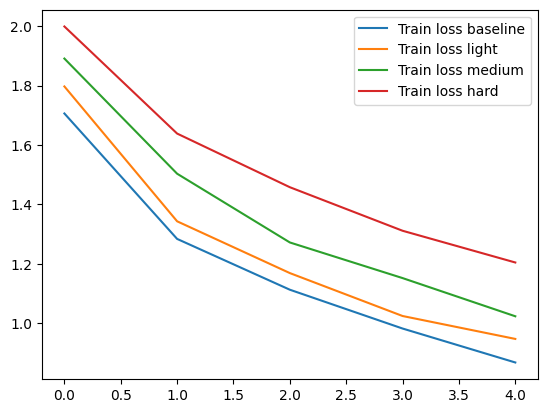

In [95]:
for transform_name, transform in train_transforms.items():
    print(f"Training with {transform_name} augmentation")
    run = wandb.init(project="animal_classification", name=f"big_augmentation_{transform_name}")
    train_dataset = ImageDataset(train_x, train_y, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

    model = baseCNN(num_classes).to(device)
    loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
    sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss {transform_name}")
    print(f"Evaluating model trained with {transform_name} augmentation")
    test_dataset = ImageDataset(test_x, test_y, transform=eval_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    pred, target = evaluate(test_loader, model)
    run.log({
            "train_loss": loss_vals,
            "transform": transform_name,
            "test_accuracy": accuracy_score(target, pred),
            "test_precision": precision_score(target, pred, average='weighted'),
            "test_recall": recall_score(target, pred, average='weighted'),
            "test_f1": f1_score(target, pred, average='weighted')
        })
    run.finish()

Conclusion on augumentations:
After testing different augumentations we can see that best results shows that baseline is enough for this dataset because it is the best one.